In [1]:
%load_ext autoreload
%autoreload 2
main_dir = r'../../..'
data_path = main_dir+'/data'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *
import os


In [2]:
data_dir = f'{main_dir}/Snapshots/1/full-fe-2809-2-labelenc'
p = Pipeline(working_folder=f'{main_dir}/Snapshots/1/Dynamics_pca_timefreq_09504')

p.add_node(LoaderNode, None, 'data',
           params={
               'input_directory': data_dir,
               'file': 'label_encoded_data.pkl'
           })
p.add_node(LoaderNode, None, 'oof',
           params={
               'input_directory': main_dir+'/data/sub',
               'file': 'oof_all_data_best_lgb_timefreq.csv'
           })
p.add_node(LoaderNode, None, 'predictions',
           params={
               'input_directory': main_dir+'/data/sub',
               'file': 'prediction_all_data_best_lgb_timefreq.csv'
           })
p.run(verbose=True)
p.save()

---------------------------
0: LoaderNode [2019-09-28 19:03:19]
params:
 {'input_directory': '../../../Snapshots/1/full-fe-2809-2-labelenc', 'file': 'label_encoded_data.pkl'}
---------------------------
1: LoaderNode [2019-09-28 19:03:22]
params:
 {'input_directory': '../../../data/sub', 'file': 'oof_all_data_best_lgb_timefreq.csv'}
---------------------------
2: LoaderNode [2019-09-28 19:03:23]
params:
 {'input_directory': '../../../data/sub', 'file': 'prediction_all_data_best_lgb_timefreq.csv'}


In [3]:
df = p.data['data']
df = df[['isFraud', 'new_card_id']]

In [4]:
pred = pd.concat([p.data['oof'].set_index('TransactionID')['isFraud'],p.data['predictions'].set_index('TransactionID')['isFraud']],axis=0)#
pred.index

Int64Index([2987000, 2987001, 2987002, 2987003, 2987004, 2987005, 2987006,
            2987007, 2987008, 2987009,
            ...
            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,
            4170237, 4170238, 4170239],
           dtype='int64', name='TransactionID', length=1097231)

In [5]:
pred

TransactionID
2987000    0.006319
2987001    0.004095
2987002    0.003470
2987003    0.001668
2987004    0.002614
             ...   
4170235    0.003462
4170236    0.002098
4170237    0.001797
4170238    0.003062
4170239    0.002060
Name: isFraud, Length: 1097231, dtype: float64

In [6]:
df['pred_0'] = pred

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df

,isFraud,new_card_id,pred_0
TransactionID,,,
2987000,0,90165,0.006319
2987001,0,137,0.004095
2987002,0,105,0.003470
2987003,0,529,0.001668
2987004,0,9324,0.002614
...,...,...,...
4170235,-1,25,0.003462
4170236,-1,32656,0.002098
4170237,-1,152,0.001797


In [8]:
test = df[['pred_0','new_card_id']].groupby('new_card_id').shift()

In [9]:
shifts = {}
for shift in range(-20,20):
    s = df[['pred_0','new_card_id']].groupby('new_card_id').shift(shift)['pred_0']
    shifts[shift] = s

In [10]:
for k,v in shifts.items():
    if k!=0:
        df[f'pred_{k}']=v

c:\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df = df.fillna(-1)

In [12]:
X = df[df.isFraud>=0].drop(['isFraud'],axis=1)
y = df[df.isFraud>=0]['isFraud']
test = df[df.isFraud<0].drop(['isFraud'],axis=1)


In [13]:
X

,new_card_id,pred_0,pred_-20,pred_-19,pred_-18,pred_-17,pred_-16,pred_-15,pred_-14,pred_-13,...,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,90165,0.006319,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987001,137,0.004095,0.006338,0.000916,0.000852,0.000789,0.157567,0.026865,0.014012,0.003320,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987002,105,0.003470,0.000204,0.000375,0.003269,0.000829,0.000709,0.000846,0.000730,0.000544,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987003,529,0.001668,0.001242,0.001456,0.001776,0.005685,0.008501,0.007135,0.002135,0.001777,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2987004,9324,0.002614,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.020629,0.000524,0.000990,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,120314,0.000612,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577536,18607,0.001739,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3577537,202,0.000314,0.002689,0.600241,0.070511,0.005953,0.001572,0.001668,0.002720,0.003389,...,0.000549,0.000921,0.000697,0.002141,0.001854,0.000717,0.007580,0.003921,0.005077,0.000969


In [14]:
categorical_features = [c for c, col in enumerate(X.columns) if col in ['new_card_id']]


In [19]:
params = {'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.5899927210061127,
          'reg_lambda': 0.8485237330340494,
          'random_state': 47, 
#           'categorical_feature': categorical_features,
         }


In [20]:
from sklearn.model_selection import KFold
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [21]:
from BayDS.lib.training import *

Fold 1 started at Sat Sep 28 19:03:59 2019
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.949644	training's auc: 0.949638	valid_1's auc: 0.921811	valid_1's auc: 0.921648
[200]	training's auc: 0.953872	training's auc: 0.953868	valid_1's auc: 0.922052	valid_1's auc: 0.922044
[300]	training's auc: 0.957046	training's auc: 0.957046	valid_1's auc: 0.921869	valid_1's auc: 0.921869
[400]	training's auc: 0.959033	training's auc: 0.959033	valid_1's auc: 0.921616	valid_1's auc: 0.921614
[500]	training's auc: 0.96096	training's auc: 0.96096	valid_1's auc: 0.921227	valid_1's auc: 0.921227
[600]	training's auc: 0.962804	training's auc: 0.962804	valid_1's auc: 0.920933	valid_1's auc: 0.920931
[700]	training's auc: 0.964467	training's auc: 0.964467	valid_1's auc: 0.920742	valid_1's auc: 0.920743
[800]	training's auc: 0.966052	training's auc: 0.966052	valid_1's auc: 0.920609	valid_1's auc: 0.920609
[900]	training's auc: 0.967611	training's auc: 0.967611	valid_1

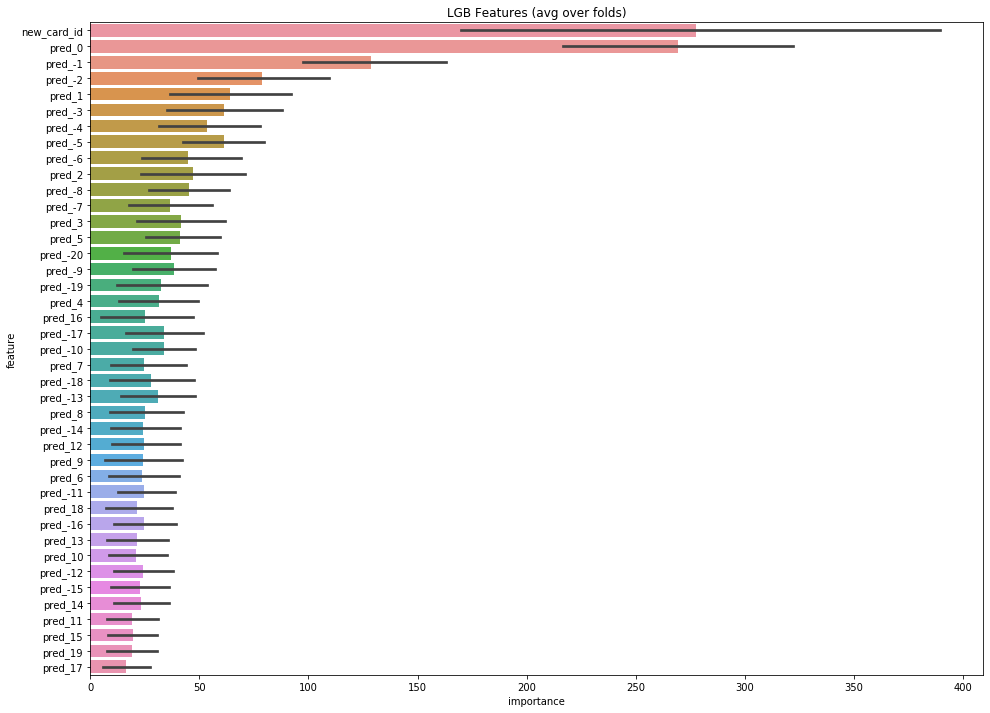

In [22]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=100, early_stopping_rounds=1000, n_estimators=5000, averaging='usual', groups=None)

In [23]:
import pickle
pickle.dump(result_dict_lgb, open(f'{p.working_folder}/results_dict_lgbm_20_train2_best.pkl','wb'))

In [24]:
# test = test.sort_values('Date')
test['prediction'] = result_dict_lgb['prediction']

In [25]:
# folder_path = './data/'
sub = pd.read_csv(f'{data_path}/sample_submission.csv')
sub['isFraud'] = pd.merge(sub, test['prediction'], on='TransactionID')['prediction']
sub.to_csv(f'{p.working_folder}/submission_dynamic_lgbm_20_best_tr2.csv', index=False)